# XAI Beyond Classification: Interpretable Neural Clustering
Journal of Machine Learning Research 23 (2022) 1-28 | Submitted 6/19; Revised 9/21; Published 2/22

*Xi Peng, Yunfan Li, Ivor W. Tsang, Hongyuan Zhu, Jiancheng Lv, Joey Tianyi Zhou.*

### Links:
- JMLR publication of the paper - [link](https://www.jmlr.org/papers/v23/19-497.html)
- PDF of the article - [link](https://www.jmlr.org/papers/volume23/19-497/19-497.pdf)
- The provided code by the authors of the paper - [link](https://github.com/XLearning-SCU/2022-JMLR-TELL)

### Notes:
- When mentioning section and/or equation, it is referred as the section and/or equation in the paper that we are summarizing.
    - Example: Equation (4) in section 2.2.1 expands the formula... 
    
- When referring to a section and/or equation that is in this work it will be explicitly noted as to avoid confusion.

## Summary and main ideas

### Quick introduction

The **main problem** that the paper tries to solve is better understanding how NN models learn and behave when training to *avoid laborious hyper-parameter tuning*. **The reason this paper exists** is that it solves this problem by implementing $k$-means clustering as a differentiable layer that can be put in any neural network model. Using $k$-means clustering groups objects together based on similarity which gives information about the characteristics of an object. These characteristics are essentially information that we can then use to make better choices.

> For example we observe that the subspecies of a flower have different length of petals. If we group the subspecies in groups A and B, where every group has a specific petal length, we can then examine a new sample (flower) and compare it's petal length to those of A and B. The grouping by a specific characteristic(s) gives us this ability to assign one flower to A and B. Similarly, this analysis can be used in NN to better understand not only what their results might be, but to also understand how the data changes while being processed by the model.

### Paper Summary
As of the writing of this paper (submitted 6/19 and published 2/22), most of the work on XAI that uses clustering is to handle high-dimensional data that can be linearly separated. The methods used by the community of researchers, mainly post-hoc and "back box" models, are hard to understand and require time consuming hyper-parameter tuning. 

Xi Peng's team introduce TELL, which as mentioned in the introduction, is a differentiable $k$-means clustering layer. The key points that make TELL interpretable is that:

 1) Each component of the cluster layer (input, weight parameters, activation, and loss function) is understandable. The weight parameters ($W$) represent cluster centers ($\Omega$), and the activation function (argmax) is used for clustering by assigning each data point to the nearest cluster center.
 2) The loss function is a reformulation of the k-means clustering algorithm, which is a transparent and well-understood.
 3) To further support the claim of interpretability, the authors provide post-hoc visualizations of the cluster centers reconstructed from the model. These visualizations correspond to recognizable digits from the MNIST dataset (section 4.3), demonstrating that the TELL method can capture intrinsic semantic meanings in the data.

### Adapting k-means into a neural layer
In order to adapt $k$-means clustering we have to give it a new loss (objective) function. The original definition of $k$-means clustering is:

$$\arg\min_{S} \sum_{j} \sum_{X_i \in S_j} \left\| X_i - \Omega_j \right\|_2^2$$

Where for a dataset $X_i$ we try to group every element of dataset to a new set $S$ by minimizing the *distance* between each data point and its group's cluster $\Omega_j$. Note that $\Omega_j$ is given as:

$$\Omega_j = \frac{1}{|S_j|} \sum_{X_i \in S_j} X_i,$$

The authors explain that this vanilla approach suffers from a few faults; 1) NP-complexity; 2) The need to compute the clusters centers at each iteration, making it impossible for large scale operations, since we generally pass the data with batches. It is then given the implementation of the main part of the algorithm.

The researchers "recast" the original objective function like so:

$$\min \sum_{i=1}^{n} \sum_{j=1}^{k} \mathcal{I}_j(X_i) \left\| X_i - \Omega_j \right\|_2^2,$$

Where  $\mathcal{I}_j(X_i)$ is denoted as the cluster membership of $X_i$ w.r.t. to $\Omega_j$ (the cluster). The right side of the equation $\left\| X_i - \Omega_j \right\|_2^2$ can be expanded by the simple $(a-b)^2 = a^2 - 2ab + b^2$, which we learn in school. In our case though we have:

$$\left\| X_i - \Omega_j \right\|_2^2 = \left\| X_i \right\|_2^2 - 2\Omega_j^\top X_i + \left\| \Omega_j \right\|_2^2$$

And in order to implement the weight and bias into the equation we recast:

$$W_j = 2\Omega_j, \quad b_j = -\left\| \Omega_j \right\|_2^2, \quad \left\| X_i \right\|_2^2 = \beta_i \geq 0,$$

Where we have $W_j$ as the $j$-th column of the weights matrix $W$. $b$, a scaler which is the $j$-th entry of the bias ($b$) during iteration and $\beta_i$ which is the length of the input data $X_i$. The authors then reformulate $\left\| X_i - \Omega_j \right\|_2^2$ as:

$$\left\| X_i - \Omega_j \right\|_2^2 = \beta_i - W_j^\top X_i - b_j$$

Which then can be expanded into:

$$\mathcal{I}_j(X_i) = \frac{\exp\left((W_j^\top X_i + b_j - \beta_i) / \tau\right)}{\sum_k \exp\left((W_k^\top X_i + b_k - \beta_k) / \tau\right)}.$$

Where $\tau$ is a temperature factor which cannot be equal to 0.

The authors then expand this formula in equations (9), (10) and (11) in which they prove that the need for decoupling $W_j$ and $b$ as well as normalizing $\Omega_j$ to be equal to 1 by dividing it by its length - $\Omega_j = \frac{\Omega_j}{\|\Omega_j\|}$. We then get a final cost function for a single sample ($x$) as:

$$\mathcal{L} = \sum_{j} \mathcal{L}_j = \sum_{j} \mathcal{I}_j(2 - W_j^\top x).$$

Now this part I could't really understand - The authors want to utilize "deep representation" to boost clustering performance and extract more relevant features not directly from the feature space, but to use auto-encoders "to extracted more discriminative features $h$" (page 8). To do that they calculate $h$ and the loss of this reconstructed space as:

$$h_i = f(X_i),$$
$$\hat{X}_i = g(h_i),$$
$$\mathcal{L}_{\text{rec}} = \sum_{i} \| X_i - \hat{X}_i \|_2^2,$$

Which they then apply to the cluster loss $\mathcal{L}_{\text{clu}}$ function as:

$$\mathcal{L} = \mathcal{L}_{\text{rec}} + \lambda \mathcal{L}_{\text{clu}} = $$

$$\sum_{i} \left\| X_i - g(f(X_i)) \right\|_2^2 + \lambda \sum_{i,j} \mathcal{I}_j(X_i)(2 - W_j^\top f(X_i))$$

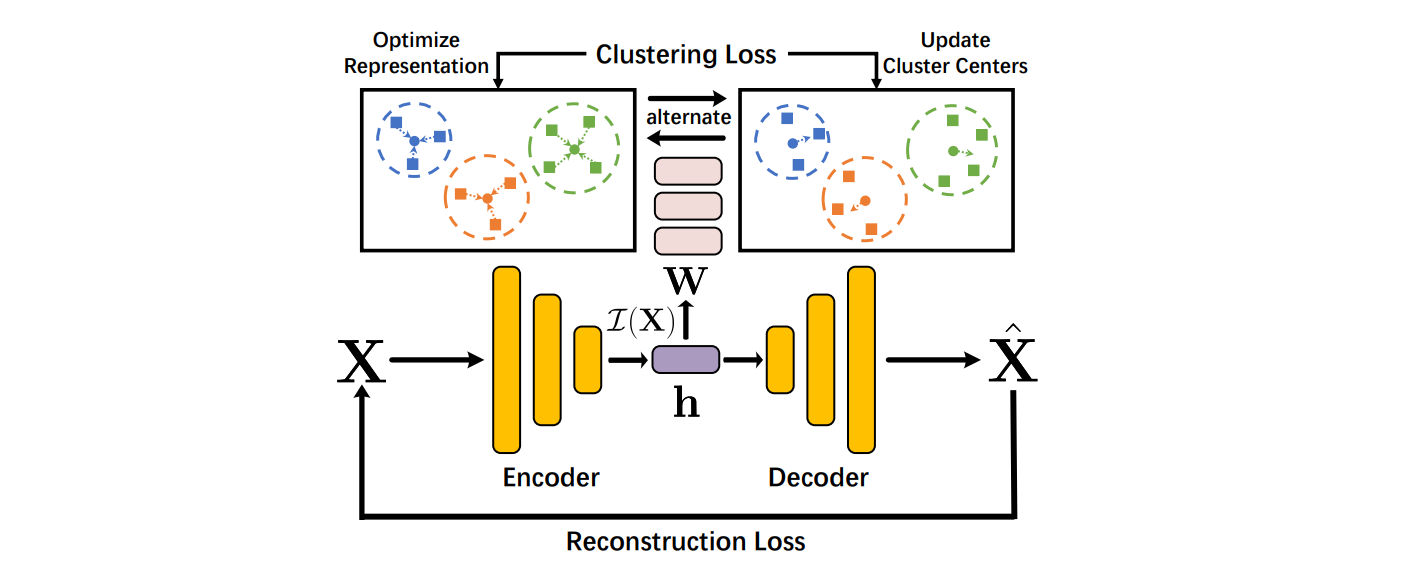

By doing this we both optimize/update the data points and clusters, not only the cluster center which is the usual case. This can be seen in the diagram above.

### Experiments
The authors test TELL on MNIST, CIFAR-10, and CIFAR-100 datasets with Clustering Accuracy (ACC), Normalized Mutual Information (NMI), and Adjusted Rand Index (ARI) for metrics (section 4.1) with a provided model architecture:

- Encoder: Four convolutional layers with configurations

- Two-layer MLP (Multi-Layer Perceptron) following the convolutional layers with:

- Batch Normalization: Applied after each convolutional layer to stabilize learning and improve convergence.

- Activation: ReLU activation function is used after each layer except the last.

- Decoder: Mirrored from the encoder architecture, with a sigmoid activation at the output layer to reconstruct the input data.

- Initialization: Both the autoencoder and the cluster layer are initialized using Kaiming uniform initialization.

- Training: The model is trained for 3000 epochs using the Adadelta optimizer, with the cluster layer designed to minimize the clustering loss.

- Clustering Layer: Details are not explicitly given, but it involves a cluster layer that is trained along with the autoencoder, likely to perform the clustering based on the features extracted by the autoencoder.

### Reproducibility

Here we will implement $k$-means clustering in a NN that classifies the MNIST dataset. This is the same task and experimentation as the researchers have done in the paper. 

Code provided by the researchers has been used in this section for reproducing test results. Most notably, the model architecture has been copied exactly as to ensure 1:1 correspondence with the paper. Other functions, like the one for saving the models and training have been modified to fit the need of this specific work. 

The results of this reproduction have showed similar results to the ones shown in the paper, **mainly** the similarity in the behavior between this work and the paper in the reconstruction of the MNIST digits using the data from the $k$-means clustering as well as observing the exact same faults (confusing one digit with another) in the same test.

Since this section requires training I have done everything in kaggle and the work can be found [here](https://www.kaggle.com/code/momchilgeorgiev/tell-nb/notebook). Now I will copy the code here locally so to be easier to check and see the work. 

Every output is saved from the kaggle notebook. This is done to save time, it is fully possible for one to rerun the code to see the raw outputs here locally or in kaggle.

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os

import torch
from torch import nn
import torch.nn.functional as F

import numpy as np
from sklearn import metrics
from munkres import Munkres

from torch.utils.data import DataLoader, ConcatDataset
import torchvision
from torchvision.datasets.mnist import MNIST

from pickle import FALSE
from sklearn.manifold import TSNE

### Define model architecture 

In [ ]:
class Net(nn.Module):
    def __init__(self, dim, class_num):
        super(Net, self).__init__()
        self.class_num = class_num
        self.encoder = nn.Sequential(
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(dim, 500, bias=True),
            nn.ReLU(),
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(500, 500, bias=True),
            nn.ReLU(),
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(500, 2000, bias=True),
            nn.ReLU(),
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(2000, 10, bias=True),
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 2000, bias=True),
            nn.ReLU(),
            nn.Linear(2000, 500, bias=True),
            nn.ReLU(),
            nn.Linear(500, 500, bias=True),
            nn.ReLU(),
            nn.Linear(500, dim, bias=True),
            nn.Sigmoid(),
        )
        
        # Here the cluster layer is being initialized
        self.cluster_layer = nn.Linear(10, class_num, bias=False)
        self.cluster_center = torch.rand([class_num, 10], requires_grad=False).cuda()

    def encode(self, x):
        x = self.encoder(x)
        x = F.normalize(x)
        return x

    def decode(self, x):
        return self.decoder(x)
    
    # This part of the class implements the clustering layer
    # in the NN    
    def cluster(self, z):
        return self.cluster_layer(z)

    def init_cluster_layer(self, alpha, cluster_center):
        self.cluster_layer.weight.data = 2 * alpha * cluster_center

    def compute_cluster_center(self, alpha):
        self.cluster_center = 1.0 / (2 * alpha) * self.cluster_layer.weight
        return self.cluster_center

    def normalize_cluster_center(self, alpha):
        self.cluster_layer.weight.data = (
            F.normalize(self.cluster_layer.weight.data, dim=1) * 2.0 * alpha
        )

    def predict(self, z):
        distance = torch.cdist(z, self.cluster_center, p=2)
        prediction = torch.argmin(distance, dim=1)
        return prediction

    def set_cluster_centroid(self, mu, cluster_id, alpha):
        self.cluster_layer.weight.data[cluster_id] = 2 * alpha * mu


class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view((x.size(0),) + self.shape)


class NetConv(Net):
    def __init__(self, channel, inner_dim, class_num):
        super(NetConv, self).__init__(dim=inner_dim, class_num=class_num)
        self.class_num = class_num
        self.inner_dim = inner_dim
        self.kernel_size = int(math.sqrt(inner_dim / 16))
        self.encoder = nn.Sequential(
            nn.Conv2d(channel, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(inner_dim, 256, bias=True),
            nn.ReLU(),
            nn.Linear(256, 10, bias=True),
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 256, bias=True),
            nn.ReLU(),
            nn.Linear(256, inner_dim, bias=True),
            Reshape(16, self.kernel_size, self.kernel_size),
            nn.ConvTranspose2d(
                16, 32, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(
                32, 16, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, channel, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid(),
        )

### Evaluation metrics for the model

As noted in the paper, the main metrics used for model evaluation are Clustering Accuracy (ACC), Normalized Mutual Information (NMI), and Adjusted Rand Index (ARI) which are calculated using `sklearn`.

- **NMI** is the normalized version (range 0 to 1) of MI which measures the similarity between labels

- **ARI** computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.

Other metrics that are used by the researchers are V-measure, homogeneity and completeness:

- **Completeness** checks if datapoints of a specific class are clustered together under the same group/cluster (source: sklearn).

- **Homogeneity** checks if the members of a specific cluster have the same class (source: sklearn).

- **V-score** is a harmonic mean between these two (source: sklearn).

In [ ]:
def evaluate(label, pred):
    nmi = metrics.normalized_mutual_info_score(label, pred)
    ari = metrics.adjusted_rand_score(label, pred)
    pred_adjusted = get_y_preds(label, pred, len(set(label)))
    acc = metrics.accuracy_score(pred_adjusted, label)
    return nmi, ari, acc


def evaluate_others(label, pred):
    ami = metrics.adjusted_mutual_info_score(label, pred)
    homo, comp, v_mea = metrics.homogeneity_completeness_v_measure(label, pred)
    return ami, homo, comp, v_mea


def calculate_cost_matrix(C, n_clusters):
    cost_matrix = np.zeros((n_clusters, n_clusters))
    # cost_matrix[i,j] will be the cost of assigning cluster i to label j
    for j in range(n_clusters):
        s = np.sum(C[:, j])  # number of examples in cluster i
        for i in range(n_clusters):
            t = C[i, j]
            cost_matrix[j, i] = s - t
    return cost_matrix


def get_cluster_labels_from_indices(indices):
    n_clusters = len(indices)
    cluster_labels = np.zeros(n_clusters)
    for i in range(n_clusters):
        cluster_labels[i] = indices[i][1]
    return cluster_labels


def get_y_preds(y_true, cluster_assignments, n_clusters):
    
    confusion_matrix = metrics.confusion_matrix(
        y_true, cluster_assignments, labels=None
    )
    # compute accuracy based on optimal 1:1 assignment of clusters to labels
    cost_matrix = calculate_cost_matrix(confusion_matrix, n_clusters)
    indices = Munkres().compute(cost_matrix)
    kmeans_to_true_cluster_labels = get_cluster_labels_from_indices(indices)

    if np.min(cluster_assignments) != 0:
        cluster_assignments = cluster_assignments - np.min(cluster_assignments)
    y_pred = kmeans_to_true_cluster_labels[cluster_assignments]
    return y_pred

### Model trainig

You can change the saving directory, here it is the default kaggle one which needs to be first created.

The model will be trained for 30 epochs and then visualized. Due to time constraints I cannot run it for 3000 epochs as the researchers did.

The model is being saved every 10 epochs. The checkpoints can be found in my project repo at hugging face (named `Models.zip`) - [link](https://huggingface.co/MGeorgieff/ResNet151V2_GRADCAM/tree/main), or one can train the model from scratch.

Also for every 10 epochs we will calculate the NMI, ARI and ACC as well as reconstruct the MNIST digits (more on that below).

In [ ]:
!mkdir /kaggle/working/save

In [ ]:
def save_model(model, optimizer, current_epoch):
    # Change the saving dir if running locally!
    out = os.path.join("/kaggle/working/save/checkpoint_{}.tar".format(current_epoch))
    state = {
        "net": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "epoch": current_epoch,
    }
    torch.save(state, out)


def inference():
    net.compute_cluster_center(alpha)
    net.eval()
    feature_vector = []
    labels_vector = []
    pred_vector = []
    with torch.no_grad():
        for step, (x, y) in enumerate(data_loader_test):
            x = x.cuda()
            with torch.no_grad():
                z = net.encode(x)
                pred = net.predict(z)
            feature_vector.extend(z.detach().cpu().numpy())
            labels_vector.extend(y.numpy())
            pred_vector.extend(pred.detach().cpu().numpy())
    feature_vector = np.array(feature_vector)
    labels_vector = np.array(labels_vector)
    pred_vector = np.array(pred_vector)
    return feature_vector, labels_vector, pred_vector


def visualize_cluster_center():
    with torch.no_grad():
        cluster_center = net.compute_cluster_center(alpha)
        reconstruction = net.decode(cluster_center)

    plt.figure()
    unique_indx = np.random.randint(0, 100)
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(
            reconstruction[i]
            .detach()
            .cpu()
            .numpy()
            .reshape(dataset[0][0].shape[1], dataset[0][0].shape[2]),
            cmap="gray",
        )
    plt.savefig(f"./cluster_center{unique_indx}.png")
    plt.close()
# Set seed for pytorch
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
reload = False
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),])

train_dataset = MNIST(
    root="./datasets", train=True, download=True, transform=transforms
)

test_dataset = MNIST(
    root="./datasets", train=False, download=True, transform=transforms
)

dataset = ConcatDataset([train_dataset, test_dataset])
class_num = 10
batch_size = 256

data_loader = DataLoader(
    dataset, batch_size=batch_size, shuffle=True, drop_last=True
)
data_loader_test = DataLoader(
    dataset, batch_size=500, shuffle=False, drop_last=False
)

# Create the model, set hyperparams
net = NetConv(channel=1, inner_dim=784, class_num=class_num).cuda()
optimizer = torch.optim.Adadelta(net.parameters())
criterion = nn.MSELoss(reduction="mean")
start_epoch = 0
epochs = 30
alpha = 0.001
net.normalize_cluster_center(alpha)

if reload:
    model_fp = os.path.join("./save/checkpoint_3000.tar")
    checkpoint = torch.load(model_fp)
    net.load_state_dict(checkpoint["net"], strict=False)
    optimizer.load_state_dict(checkpoint["optimizer"])
    start_epoch = checkpoint["epoch"]
    
for epoch in range(start_epoch, epochs):
    loss_clu_epoch = loss_rec_epoch = 0
    net.train()
    for step, (x, y) in enumerate(data_loader):
        x = x.cuda()
        z = net.encode(x)

        if epoch % 2 == 1:
            cluster_batch = net.cluster(z)
        else:
            cluster_batch = net.cluster(z.detach())
        soft_label = F.softmax(cluster_batch.detach(), dim=1)
        hard_label = torch.argmax(soft_label, dim=1)
        delta = torch.zeros((batch_size, 10), requires_grad=False).cuda()
        for i in range(batch_size):
            delta[i, torch.argmax(soft_label[i, :])] = 1
        loss_clu_batch = 2 * alpha - torch.mul(delta, cluster_batch)
        loss_clu_batch = 0.01 / alpha * loss_clu_batch.mean()

        x_ = net.decode(z)
        loss_rec = criterion(x, x_)

        loss = loss_rec + loss_clu_batch
        optimizer.zero_grad()
        loss.backward()
        if epoch % 2 == 0:
            net.cluster_layer.weight.grad = (
                F.normalize(net.cluster_layer.weight.grad, dim=1) * 0.2 * alpha
            )
        else:
            net.cluster_layer.zero_grad()
        optimizer.step()
        net.normalize_cluster_center(alpha)
        loss_clu_epoch += loss_clu_batch.item()
        loss_rec_epoch += loss_rec.item()
    print(
        f"Epoch [{epoch}/{epochs}]\t Clu Loss: {loss_clu_epoch / len(data_loader)}\t Rec Loss: {loss_rec_epoch / len(data_loader)}"
    )

    if epoch % 10 == 0:
        visualize_cluster_center()
        feature, label, pred = inference()
        nmi, ari, acc = evaluate(label, pred)
        print("Model NMI = {:.4f} ARI = {:.4f} ACC = {:.4f}".format(nmi, ari, acc))
        ami, homo, comp, v_mea = evaluate_others(label, pred)
        print(
            "Model AMI = {:.4f} Homogeneity = {:.4f} Completeness = {:.4f} V_Measure = {:.4f}".format(
                ami, homo, comp, v_mea
            )
        )
        print("Image saved!")
        save_model(net, optimizer, epoch)

Cluster center reconstruction - this means feeding the cluster representations to the model decoder so to reconstruct the digits using the learned values by TELL. The researchers show their results in fig. 5 in the study but for larger number of epochs. Here from left to right the reconstructions are for 0, 10 and 20 epochs:

<img src="./cluster_center12.png" style="height:200px" />
<img src="./cluster_center37.png" style="height:200px" />
<img src="./cluster_center72.png" style="height:200px" />

We can observe that in early stages, the algorithm cannot fully reconstruct "8", "4" and "9" (the digits are blurry). This is the same behaviour as in the paper:

<img src="../2022-JMLR-TELL/digits1.png" style="height:100px" />

> fig. 5 of the paper

As the paper notes, more epochs are needed to fix this issue.

#### tSNE visualization

For visualization the paper notes on using tSNE, even though PCA can also be used here.

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

def tSNE(X, Y, epoch):
    colors = list(mcolors.TABLEAU_COLORS.keys())
    print("Performing TSNE")
    X_embedded = TSNE(n_components=2).fit_transform(X)
    plt.figure()
    N = X_embedded.shape[0] - class_num
    for i in range(N):
        if i % 1000 == 0:
            print(i, "/", N)
        label = Y[i].item()
        plt.scatter(
            X_embedded[i][0],
            X_embedded[i][1],
            color=mcolors.TABLEAU_COLORS[colors[label]],
            marker=".",
            s=1,
        )
    for i in range(class_num):
        plt.scatter(
            X_embedded[i + N][0], X_embedded[i + N][1], color="black", marker="*", s=50
        )
    plt.savefig("tSNE_epoch=" + str(epoch) + ".png")
    print("Finished")


def inference():
    net.eval()
    feature_vector = []
    labels_vector = []
    pred_vector = []
    with torch.no_grad():
        for step, (x, y) in enumerate(data_loader_test):
            x = x.cuda()
            with torch.no_grad():
                z = net.encode(x)
                pred = net.predict(z)
            feature_vector.extend(z.detach().cpu().numpy())
            labels_vector.extend(y.numpy())
            pred_vector.extend(pred.detach().cpu().numpy())
    return feature_vector, labels_vector, pred_vector


if __name__ == "__main__":
    transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),])
    train_dataset = MNIST(
        root="./datasets", train=True, download=True, transform=transforms
    )
    test_dataset = MNIST(
        root="./datasets", train=False, download=True, transform=transforms
    )
    dataset = test_dataset  # ConcatDataset([train_dataset, test_dataset])
    class_num = 10
    batch_size = 256
    alpha = 0.001
    data_loader_test = DataLoader(
        dataset, batch_size=500, shuffle=False, drop_last=False
    )
    net = NetConv(channel=1, inner_dim=784, class_num=class_num).cuda()
    epochs = [0, 10, 20]
    for epoch in epochs:
        model_fp = os.path.join("./save/checkpoint_{}.tar".format(epoch))
        checkpoint = torch.load(model_fp)
        net.load_state_dict(checkpoint["net"], strict=False)

        print("Computing features from model")
        feature, labels, pred = inference()
        cluster_center = net.compute_cluster_center(alpha)
        feature.extend(cluster_center.detach().cpu().numpy())
        feature_vector = np.array(feature)
        labels_vector = np.array(labels)
        tSNE(feature_vector, labels_vector, epoch)

Output:

<img src="./tSNE_epoch=0.png" style="height:200px" />
<img src="./tSNE_epoch=10.png" style="height:200px" />
<img src="./tSNE_epoch=20.png" style="height:200px" />

The github repo of the paper gives us the state of the clusters in the last epoch (3000th):

<img src="./tSNE_epoch=3000.png" style="height:300px" />

We can see that even on epoch 20 the cluster centers start to fit themselves into a fixed position.